In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
# from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
import shap

In [47]:
# Load the data
data = pd.read_excel('mouse_con_np_4param.xls')
values = data.values
print(values.size)
X = values[:,0:4] # input
y = values[:,4]-1 # target, change labels into 0 and 1
print(y.size)

1000
200


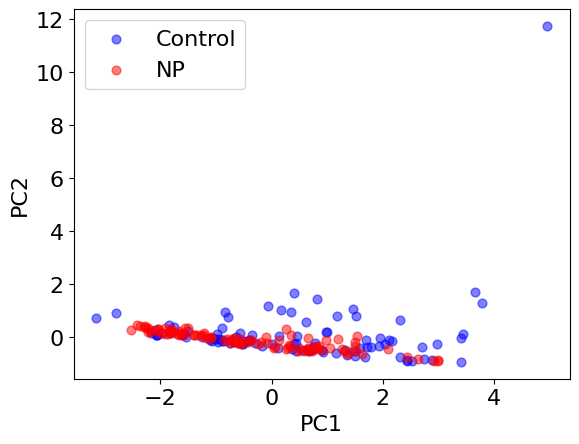

In [48]:
## Principal component analysis (PCA)
# Standardize features
X_ss = StandardScaler().fit_transform(X)
# Perform PCA
pca = PCA(n_components=2)
pc = pca.fit_transform(X_ss)
# Create a new DataFrame with principal components
df_pc = pd.DataFrame(data=pc, columns=['PC1', 'PC2'])
# Concatenate with target variable
df_pc_targ = pd.concat([df_pc, pd.DataFrame(y, columns=['Target'])], axis=1)
# Plot PCA
plt.rcParams.update({'font.size': 16})
targets = np.unique(y)
colors = ['b','r', 'g', 'b', 'y']
for target, color in zip(targets, colors):
    indices_to_keep = df_pc_targ['Target'] == target
    plt.scatter(df_pc_targ.loc[indices_to_keep, 'PC1'],
                df_pc_targ.loc[indices_to_keep, 'PC2'],
                c=color, s=40, alpha=0.5,)
plt.legend(['Control', 'NP'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('./results_mouse_con_np/pca.jpg', dpi=300, bbox_inches='tight')
plt.show()

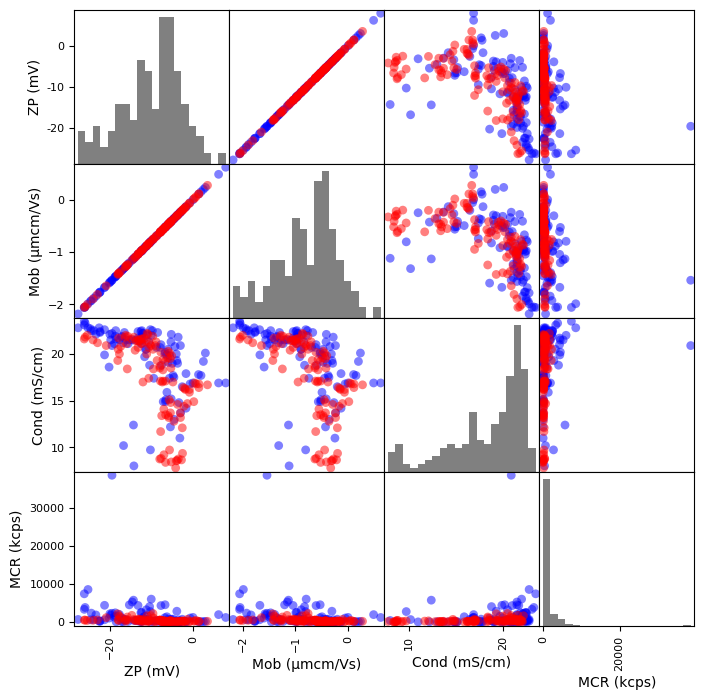

In [49]:
# Select the variables to include in the scatter matrix plot
vars_to_plot = ['ZP (mV)', 'Mob (μmcm/Vs)', 'Cond (mS/cm)', 'MCR (kcps)']
df = pd.DataFrame(X, columns=vars_to_plot)
# Create the scatter matrix plot
plt.rcParams.update({'font.size': 10})
scatter_matrix(df, c=y, figsize=(8, 8), marker='o', hist_kwds={'bins':20, 'color': 'gray'}, s=40, alpha=0.5, cmap='bwr')
plt.savefig('./results_mouse_con_np/scatter_matrix.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [50]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [51]:
# Create the models
model_LR = LogisticRegression(solver='saga', max_iter=1000)
model_SVM = SVC(probability=True)
model_kNN = KNeighborsClassifier(n_neighbors=3)
model_DT = DecisionTreeClassifier(min_samples_leaf=5, max_depth=5)
model_XGB = XGBClassifier()
# model_RFC = RandomForestClassifier(n_estimators=100)

In [52]:
# Perform 200-fold cross-validation
cv_num = 10
accu_train_LR = cross_val_score(model_LR, X_train, y_train, cv=cv_num)
accu_train_SVM = cross_val_score(model_SVM, X_train, y_train, cv=cv_num)
accu_train_kNN = cross_val_score(model_kNN, X_train, y_train, cv=cv_num)
accu_train_DT = cross_val_score(model_DT, X_train, y_train, cv=cv_num)
accu_train_XGB = cross_val_score(model_XGB, X_train, y_train, cv=cv_num)
# score_RFC = cross_val_score(model_RFC, X_train, y_train, cv=200)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


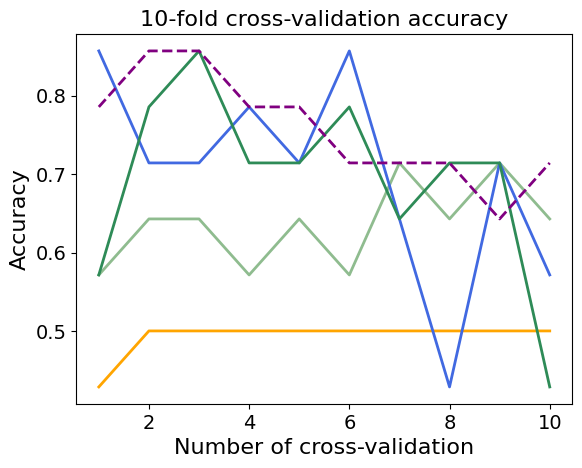

In [53]:
# Plotting the curves of cross-validation
plt.rcParams.update({'font.size': 16})
cvx = np.arange(1, cv_num+1, 1)
plt.plot(cvx, accu_train_LR, lw=2, color='orange')
plt.plot(cvx, accu_train_SVM, lw=2, color='darkseagreen')
plt.plot(cvx, accu_train_kNN, lw=2, color='royalblue')
plt.plot(cvx, accu_train_DT, lw=2, color='seagreen')
plt.plot(cvx, accu_train_XGB, lw=2, linestyle='--', color='purple')
plt.xticks(fontsize=14)
plt.xlabel('Number of cross-validation', fontsize=16)
plt.yticks(fontsize=14)
plt.ylabel('Accuracy', fontsize=16)
plt.title(str(cv_num)+'-fold cross-validation accuracy', fontsize=16)
plt.savefig('./results_mouse_con_np/cross_validation_curve_fold_'+str(cv_num)+'.jpg', dpi=300, bbox_inches='tight')
plt.show()

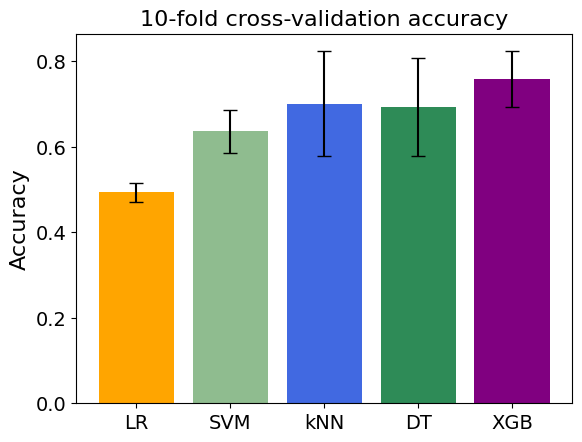

Accuracy of LR: 0.4928571428571429 0.021428571428571436
Accuracy of SVM: 0.6357142857142858 0.050000000000000024
Accuracy of kNN: 0.7 0.1228903609577518
Accuracy of DT: 0.692857142857143 0.1153963887243108
Accuracy of XGB: 0.7571428571428572 0.06546536707079768


In [54]:
# Bar chart of 200-fold cross-validation accuracy
barx_val = ['LR', 'SVM', 'kNN', 'DT', 'XGB']
bary_val = [np.mean(accu_train_LR), np.mean(accu_train_SVM), np.mean(accu_train_kNN), np.mean(accu_train_DT), np.mean(accu_train_XGB)]
bary_std = [np.std(accu_train_LR), np.std(accu_train_SVM), np.std(accu_train_kNN), np.std(accu_train_DT), np.std(accu_train_XGB)]

plt.rcParams.update({'font.size': 16})
color = ['orange', 'darkseagreen', 'royalblue', 'seagreen', 'purple']
plt.bar(barx_val, bary_val, yerr = bary_std, capsize=5, color=color)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Accuracy', fontsize=16)
plt.title(str(cv_num)+'-fold cross-validation accuracy', fontsize=16)
plt.savefig('./results_mouse_con_np/cross_validation_bar_fold_'+str(cv_num)+'.jpg', dpi=300, bbox_inches='tight')
plt.show()

print('Accuracy of LR:', np.mean(accu_train_LR), np.std(accu_train_LR))
print('Accuracy of SVM:', np.mean(accu_train_SVM), np.std(accu_train_SVM))
print('Accuracy of kNN:', np.mean(accu_train_kNN), np.std(accu_train_kNN))
print('Accuracy of DT:', np.mean(accu_train_DT), np.std(accu_train_DT))
print('Accuracy of XGB:', np.mean(accu_train_XGB), np.std(accu_train_XGB))
# print('Score of RFC:', np.mean(score_RFC))

In [55]:
# Train the best models
model_LR.fit(X_train, y_train)
model_SVM.fit(X_train, y_train)
model_kNN.fit(X_train, y_train)
model_DT.fit(X_train, y_train)
model_XGB.fit(X_train, y_train)
# model_RFC.fit(X_train, y_train)

The max_iter was reached which means the coef_ did not converge


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


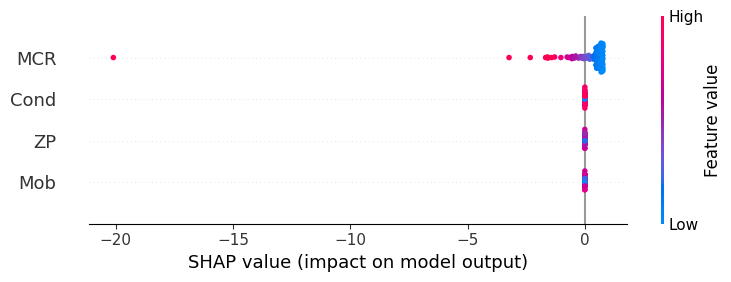

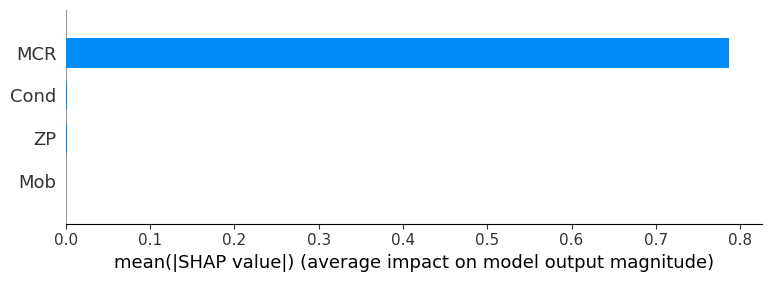

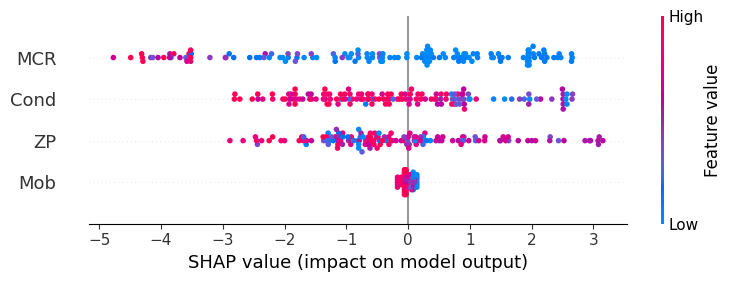

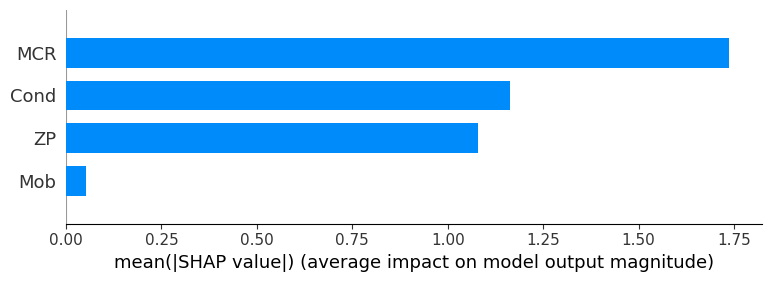

In [56]:
# Create an explainer object
# LR
explainer = shap.Explainer(model_LR, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, feature_names=["ZP", "Mob", "Cond", "MCR"])
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=["ZP", "Mob", "Cond", "MCR"])
# # SVM
# explainer = shap.Explainer(model_SVM, X_train)
# shap_values = explainer(X_train)
# shap.summary_plot(shap_values, X_train, feature_names=["ZP", "Mob", "Cond", "MCR"])
# shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=["ZP", "Mob", "Cond", "MCR"])
# # kNN
# explainer = shap.Explainer(model_kNN, X_train)
# shap_values = explainer(X_train)
# shap.summary_plot(shap_values, X_train, feature_names=["ZP", "Mob", "Cond", "MCR"])
# shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=["ZP", "Mob", "Cond", "MCR"])
# # DT
# explainer = shap.Explainer(model_DT, X_train)
# shap_values = explainer(X_train)
# shap.summary_plot(shap_values, X_train, feature_names=["ZP", "Mob", "Cond", "MCR"])
# shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=["ZP", "Mob", "Cond", "MCR"])
# XGB
explainer = shap.Explainer(model_XGB, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, feature_names=["ZP", "Mob", "Cond", "MCR"])
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=["ZP", "Mob", "Cond", "MCR"])

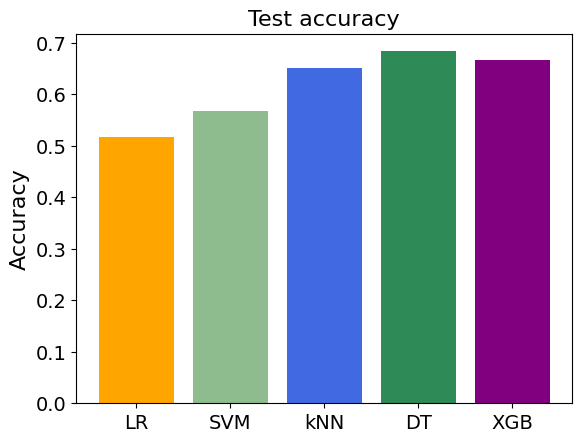

Accuracy of LR: 0.5166666666666667
Accuracy of SVC: 0.5666666666666667
Accuracy of kNN: 0.65
Accuracy of DT: 0.6833333333333333
Accuracy of XGB: 0.6666666666666666


In [57]:
# Use the model to make predictions
y_pred_LR = model_LR.predict(X_test)
y_pred_SVM = model_SVM.predict(X_test)
y_pred_kNN = model_kNN.predict(X_test)
y_pred_DT = model_DT.predict(X_test)
y_pred_XGB = model_XGB.predict(X_test)
# y_pred_RFC = model_RFC.predict(X_test)

# Evaluate the model
accu_test_LR = (y_pred_LR == y_test).sum() / len(y_test)
accu_test_SVM = (y_pred_SVM == y_test).sum() / len(y_test)
accu_test_kNN = (y_pred_kNN == y_test).sum() / len(y_test)
accu_test_DT = (y_pred_DT == y_test).sum() / len(y_test)
accu_test_XGB = (y_pred_XGB == y_test).sum() / len(y_test)
# accuracy_RFC = (y_pred_RFC == y_test).sum() / len(y_test)

# Bar chart of test accuracy
barx_test = ['LR', 'SVM', 'kNN', 'DT', 'XGB']
bary_test = [accu_test_LR, accu_test_SVM, accu_test_kNN, accu_test_DT, accu_test_XGB]
plt.rcParams.update({'font.size': 16})
color = ['orange', 'darkseagreen', 'royalblue', 'seagreen', 'purple']
plt.bar(barx_test, bary_test, color=color)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Test accuracy', fontsize=16)
plt.savefig('./results_mouse_con_np/text_bar.jpg', dpi=300, bbox_inches='tight')
plt.show()

print('Accuracy of LR:', model_LR.score(X_test,y_test))
print('Accuracy of SVC:', model_SVM.score(X_test,y_test))
print('Accuracy of kNN:', model_kNN.score(X_test,y_test))
print('Accuracy of DT:', model_DT.score(X_test,y_test))
print('Accuracy of XGB:', model_XGB.score(X_test,y_test))
# print('Accuracy of RFC:', model_RFC.score(X_test,y_test))

In [58]:
# Create a sample confusion matrix
def plot_confusion_matrix(y_true, y_pred, ax, labels, title):
    
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    im = ax.imshow(cm, cmap='Blues')

    # Add labels and colorbar
    ax.set_xticks(np.arange(len(cm)))
    ax.set_yticks(np.arange(len(cm)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(title)
    plt.colorbar(im)

    # Add annotations
    thresh = cm.max() / 2.
    for i in range(len(cm)):
        for j in range(len(cm)):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

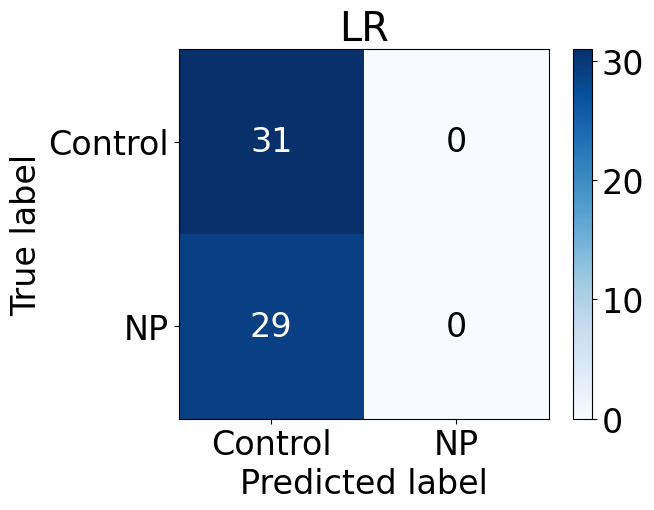

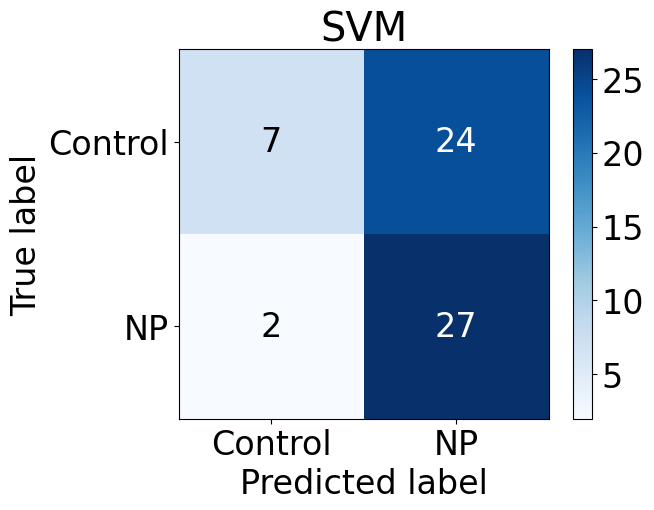

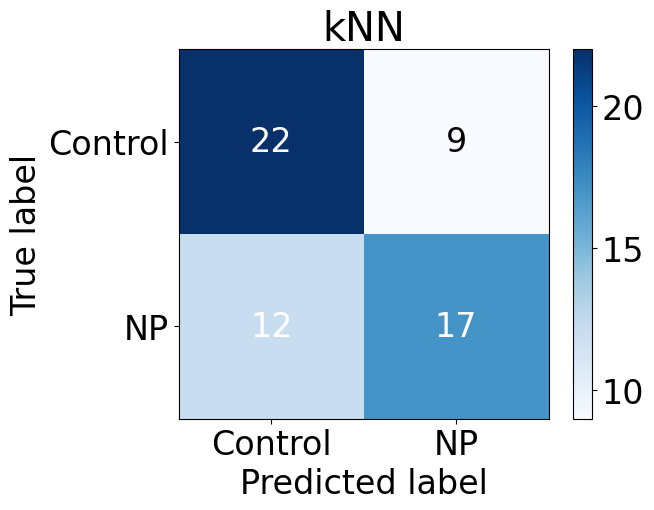

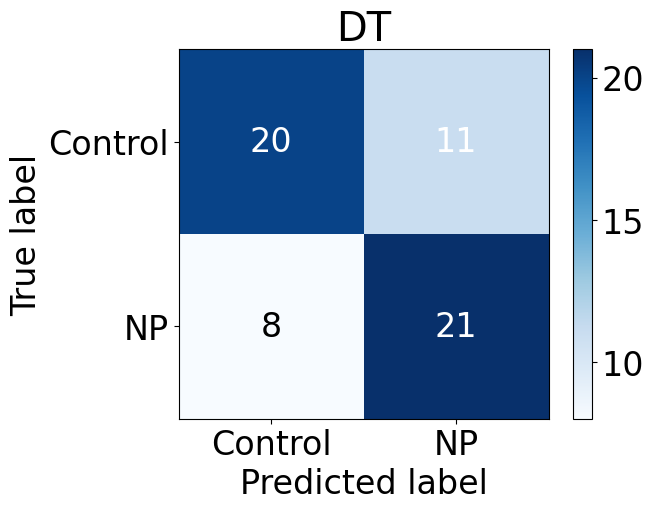

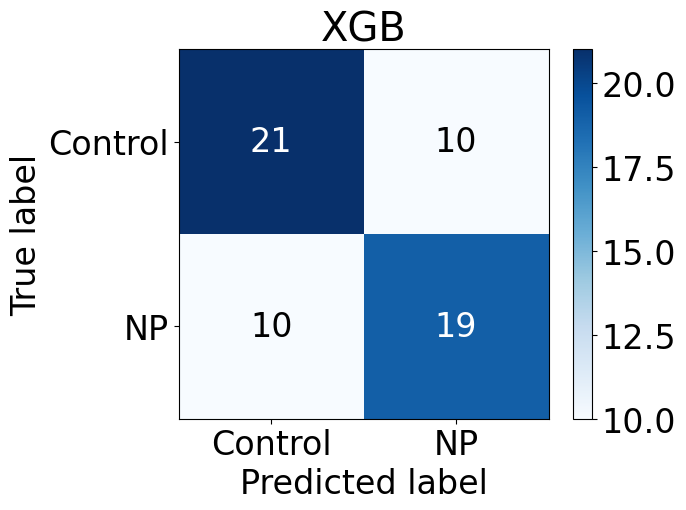

In [59]:
# Create a grid of subplots
plt.rcParams.update({'font.size': 24})
plt.figure()
ax1 = plt.subplot(1,1,1)
plot_confusion_matrix(y_test, y_pred_LR, ax1, ['Control', 'NP'], 'LR')
plt.savefig('./results_mouse_con_np/confusion_matrix_lr.jpg', dpi=300, bbox_inches='tight')
plt.show()
plt.figure()
ax2 = plt.subplot(1,1,1)
plot_confusion_matrix(y_test, y_pred_SVM, ax2, ['Control', 'NP'], 'SVM')
plt.savefig('./results_mouse_con_np/confusion_matrix_svm.jpg', dpi=300, bbox_inches='tight')
plt.show()
plt.figure()
ax3 = plt.subplot(1,1,1)
plot_confusion_matrix(y_test, y_pred_kNN, ax3, ['Control', 'NP'], 'kNN')
plt.savefig('./results_mouse_con_np/confusion_matrix_knn.jpg', dpi=300, bbox_inches='tight')
plt.show()
plt.figure()
ax4 = plt.subplot(1,1,1)
plot_confusion_matrix(y_test, y_pred_DT, ax4, ['Control', 'NP'], 'DT')
plt.savefig('./results_mouse_con_np/confusion_matrix_dt.jpg', dpi=300, bbox_inches='tight')
plt.show()
plt.figure()
ax5 = plt.subplot(1,1,1)
plot_confusion_matrix(y_test, y_pred_XGB, ax5, ['Control', 'NP'], 'XGB')
plt.subplots_adjust(wspace=-0.35, hspace=1.25)
plt.savefig('./results_mouse_con_np/confusion_matrix_xgb.jpg', dpi=300, bbox_inches='tight')
plt.show()

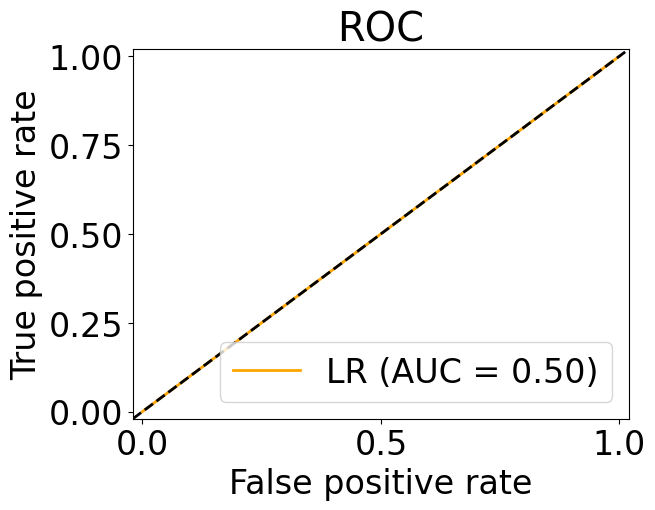

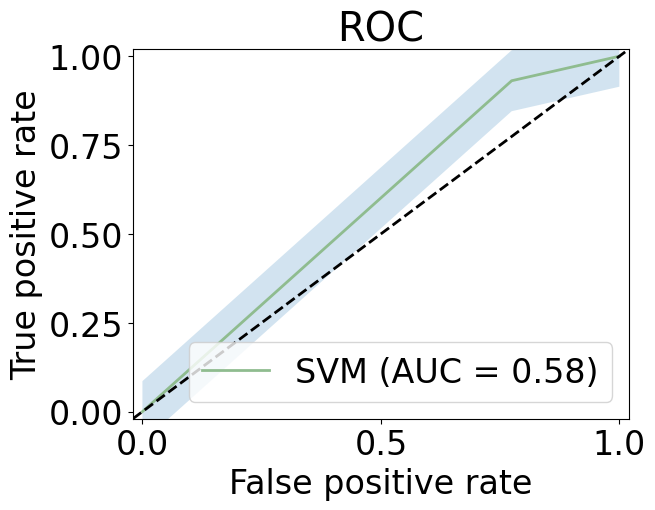

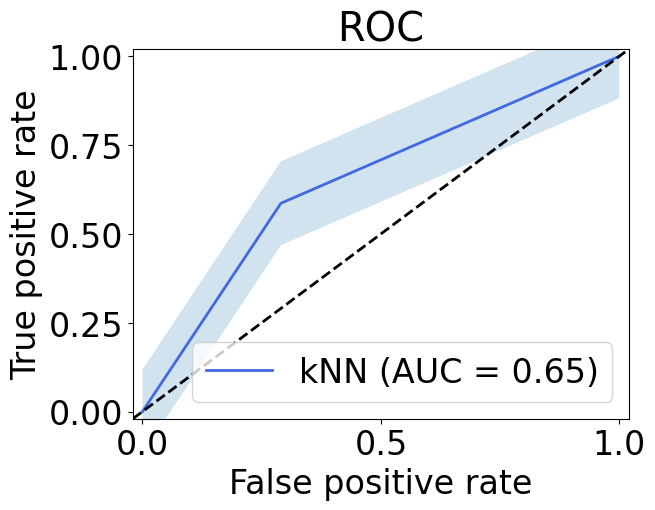

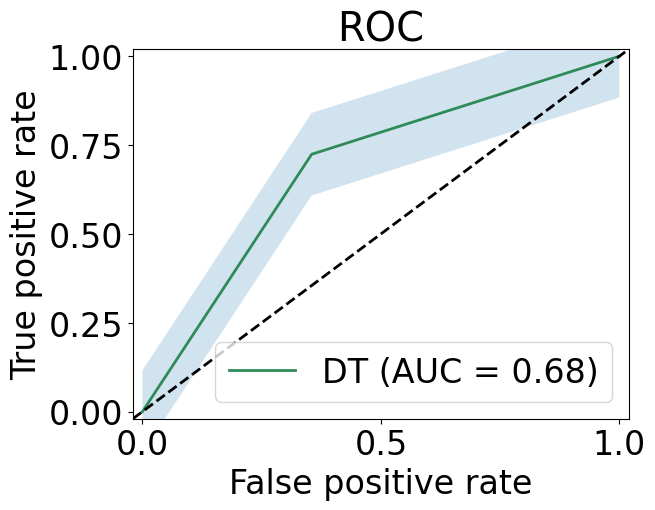

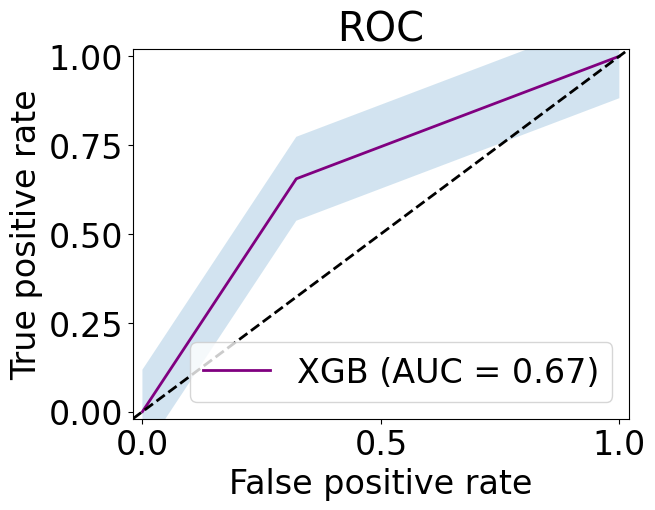

In [60]:
# Compute ROC curve and AUC score
# Plot ROC curve
plt.rcParams.update({'font.size': 24})
# Linear regression
fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_test, y_pred_LR)
roc_auc_LR = auc(fpr_LR, tpr_LR)
# Compute the confidence interval using bootstrapping
n_bootstraps = 1000
bootstrapped_auc = []
for i in range(n_bootstraps):
    # Generate a random sample with replacement
    indices = np.random.randint(0, len(y_test), size=len(y_pred_LR))
    sample_true = y_test[indices]
    sample_score = y_pred_LR[indices]
    # Compute the ROC curve for the sample
    sample_fpr, sample_tpr, sample_thresholds = roc_curve(sample_true, sample_score)
    # Compute the AUC for the sample
    sample_auc = auc(sample_fpr, sample_tpr)
    bootstrapped_auc.append(sample_auc)
# Compute the mean and standard deviation of the bootstrapped AUC values
mean_auc = np.mean(bootstrapped_auc)
std_auc = np.std(bootstrapped_auc)
plt.figure()
plt.plot(fpr_LR, tpr_LR, color='orange', lw=2, label='LR (AUC = %0.2f)' % roc_auc_LR)
plt.plot([-0.02, 1.02], [-0.02, 1.02], color='k', lw=2, linestyle='--')
plt.fill_between(fpr_LR, tpr_LR - 1.96 * std_auc, tpr_LR + 1.96 * std_auc, alpha=0.2)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate',)
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('./results_mouse_con_np/roc_lr.jpg', dpi=300, bbox_inches='tight')
plt.show()
# SVC
fpr_SVC, tpr_SVC, thresholds_SVC = roc_curve(y_test, y_pred_SVM)
roc_auc_SVC = auc(fpr_SVC, tpr_SVC)
# Compute the confidence interval using bootstrapping
n_bootstraps = 1000
bootstrapped_auc = []
for i in range(n_bootstraps):
    # Generate a random sample with replacement
    indices = np.random.randint(0, len(y_test), size=len(y_pred_SVM))
    sample_true = y_test[indices]
    sample_score = y_pred_SVM[indices]
    # Compute the ROC curve for the sample
    sample_fpr, sample_tpr, sample_thresholds = roc_curve(sample_true, sample_score)
    # Compute the AUC for the sample
    sample_auc = auc(sample_fpr, sample_tpr)
    bootstrapped_auc.append(sample_auc)
# Compute the mean and standard deviation of the bootstrapped AUC values
mean_auc = np.mean(bootstrapped_auc)
std_auc = np.std(bootstrapped_auc)
plt.figure()
plt.plot(fpr_SVC, tpr_SVC, color='darkseagreen', lw=2, label='SVM (AUC = %0.2f)' % roc_auc_SVC)
plt.plot([-0.02, 1.02], [-0.02, 1.02], color='k', lw=2, linestyle='--')
plt.fill_between(fpr_SVC, tpr_SVC - 1.96 * std_auc, tpr_SVC + 1.96 * std_auc, alpha=0.2)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('./results_mouse_con_np/roc_svm.jpg', dpi=300, bbox_inches='tight')
plt.show()
# kNN
fpr_kNN, tpr_kNN, thresholds_kNN = roc_curve(y_test, y_pred_kNN)
roc_auc_kNN = auc(fpr_kNN, tpr_kNN)
# Compute the confidence interval using bootstrapping
n_bootstraps = 1000
bootstrapped_auc = []
for i in range(n_bootstraps):
    # Generate a random sample with replacement
    indices = np.random.randint(0, len(y_test), size=len(y_pred_kNN))
    sample_true = y_test[indices]
    sample_score = y_pred_kNN[indices]
    # Compute the ROC curve for the sample
    sample_fpr, sample_tpr, sample_thresholds = roc_curve(sample_true, sample_score)
    # Compute the AUC for the sample
    sample_auc = auc(sample_fpr, sample_tpr)
    bootstrapped_auc.append(sample_auc)
# Compute the mean and standard deviation of the bootstrapped AUC values
mean_auc = np.mean(bootstrapped_auc)
std_auc = np.std(bootstrapped_auc)
plt.figure()
plt.plot(fpr_kNN, tpr_kNN, color='royalblue', lw=2, label='kNN (AUC = %0.2f)' % roc_auc_kNN)
plt.plot([-0.02, 1.02], [-0.02, 1.02], color='k', lw=2, linestyle='--')
plt.fill_between(fpr_kNN, tpr_kNN - 1.96 * std_auc, tpr_kNN + 1.96 * std_auc, alpha=0.2)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('./results_mouse_con_np/roc_knn.jpg', dpi=300, bbox_inches='tight')
plt.show()
# DT
fpr_DT, tpr_DT, thresholds_DT = roc_curve(y_test, y_pred_DT)
roc_auc_DT = auc(fpr_DT, tpr_DT)
# Compute the confidence interval using bootstrapping
n_bootstraps = 1000
bootstrapped_auc = []
for i in range(n_bootstraps):
    # Generate a random sample with replacement
    indices = np.random.randint(0, len(y_test), size=len(y_pred_DT))
    sample_true = y_test[indices]
    sample_score = y_pred_DT[indices]
    # Compute the ROC curve for the sample
    sample_fpr, sample_tpr, sample_thresholds = roc_curve(sample_true, sample_score)
    # Compute the AUC for the sample
    sample_auc = auc(sample_fpr, sample_tpr)
    bootstrapped_auc.append(sample_auc)
# Compute the mean and standard deviation of the bootstrapped AUC values
mean_auc = np.mean(bootstrapped_auc)
std_auc = np.std(bootstrapped_auc)
plt.figure()
plt.plot(fpr_DT, tpr_DT, color='seagreen', lw=2, label='DT (AUC = %0.2f)' % roc_auc_DT)
plt.plot([-0.02, 1.02], [-0.02, 1.02], color='k', lw=2, linestyle='--')
plt.fill_between(fpr_DT, tpr_DT - 1.96 * std_auc, tpr_DT + 1.96 * std_auc, alpha=0.2)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('./results_mouse_con_np/roc_dt.jpg', dpi=300, bbox_inches='tight')
plt.show()
# XGB
fpr_XGB, tpr_XGB, thresholds_XGB = roc_curve(y_test, y_pred_XGB)
roc_auc_XGB = auc(fpr_XGB, tpr_XGB)
# Compute the confidence interval using bootstrapping
n_bootstraps = 1000
bootstrapped_auc = []
for i in range(n_bootstraps):
    # Generate a random sample with replacement
    indices = np.random.randint(0, len(y_test), size=len(y_pred_XGB))
    sample_true = y_test[indices]
    sample_score = y_pred_XGB[indices]
    # Compute the ROC curve for the sample
    sample_fpr, sample_tpr, sample_thresholds = roc_curve(sample_true, sample_score)
    # Compute the AUC for the sample
    sample_auc = auc(sample_fpr, sample_tpr)
    bootstrapped_auc.append(sample_auc)
# Compute the mean and standard deviation of the bootstrapped AUC values
mean_auc = np.mean(bootstrapped_auc)
std_auc = np.std(bootstrapped_auc)
plt.figure()
plt.plot(fpr_XGB, tpr_XGB, color='purple', lw=2, label='XGB (AUC = %0.2f)' % roc_auc_XGB)
plt.plot([-0.02, 1.02], [-0.02, 1.02], color='k', lw=2, linestyle='--')
plt.fill_between(fpr_XGB, tpr_XGB - 1.96 * std_auc, tpr_XGB + 1.96 * std_auc, alpha=0.2)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('./results_mouse_con_np/roc_xgb.jpg', dpi=300, bbox_inches='tight')
plt.show()

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


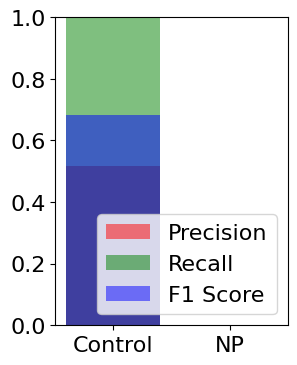

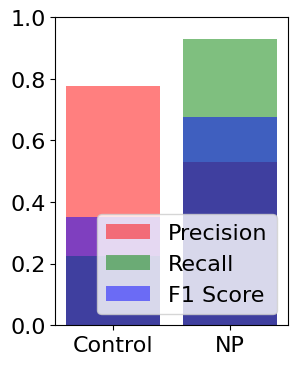

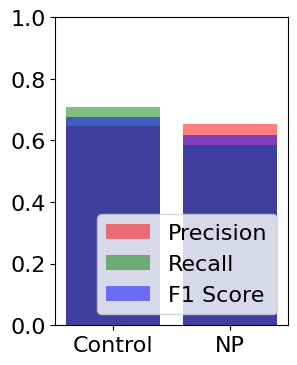

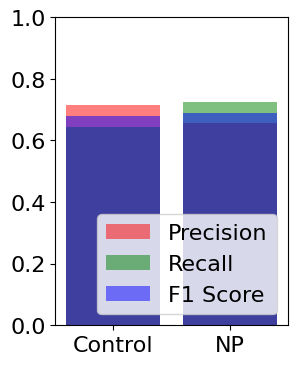

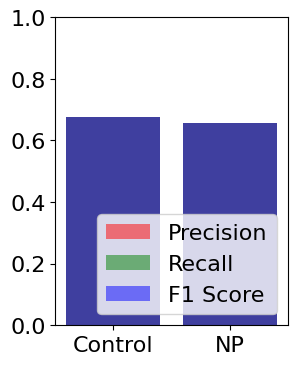

In [61]:
# Calculate the precision, recall, and F1 scores
precision_LR, recall_LR, f1_score_LR, _ = precision_recall_fscore_support(y_test, y_pred_LR, average=None)
precision_SVM, recall_SVM, f1_score_SVM, _ = precision_recall_fscore_support(y_test, y_pred_SVM, average=None)
precision_kNN, recall_kNN, f1_score_kNN, _ = precision_recall_fscore_support(y_test, y_pred_kNN, average=None)
precision_DT, recall_DT, f1_score_DT, _ = precision_recall_fscore_support(y_test, y_pred_DT, average=None)
precision_XGB, recall_XGB, f1_score_XGB, _ = precision_recall_fscore_support(y_test, y_pred_XGB, average=None)

# Define the labels for the two classes
plt.rcParams.update({'font.size': 16})
labels = ['Control', 'NP']
# Plot the precision, recall, and F1 scores
plt.figure(figsize=(3, 4))
plt.bar(labels, precision_LR, color='r', alpha=0.5, label='Precision')
plt.bar(labels, recall_LR, color='g', alpha=0.5, label='Recall')
plt.bar(labels, f1_score_LR, color='b', alpha=0.5, label='F1 Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')  # place legend outside the figure
plt.savefig('./results_mouse_con_np/prec_rec_f1_lr.jpg', dpi=300, bbox_inches='tight')
plt.show()
# Plot the precision, recall, and F1 scores
plt.figure(figsize=(3, 4))
plt.bar(labels, precision_SVM, color='r', alpha=0.5, label='Precision')
plt.bar(labels, recall_SVM, color='g', alpha=0.5, label='Recall')
plt.bar(labels, f1_score_SVM, color='b', alpha=0.5, label='F1 Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')  # place legend outside the figure
plt.savefig('./results_mouse_con_np/prec_rec_f1_svm.jpg', dpi=300, bbox_inches='tight')
plt.show()
# Plot the precision, recall, and F1 scores
plt.figure(figsize=(3, 4))
plt.bar(labels, precision_kNN, color='r', alpha=0.5, label='Precision')
plt.bar(labels, recall_kNN, color='g', alpha=0.5, label='Recall')
plt.bar(labels, f1_score_kNN, color='b', alpha=0.5, label='F1 Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')  # place legend outside the figure
plt.savefig('./results_mouse_con_np/prec_rec_f1_knn.jpg', dpi=300, bbox_inches='tight')
plt.show()
# Plot the precision, recall, and F1 scores
plt.figure(figsize=(3, 4))
plt.bar(labels, precision_DT, color='r', alpha=0.5, label='Precision')
plt.bar(labels, recall_DT, color='g', alpha=0.5, label='Recall')
plt.bar(labels, f1_score_DT, color='b', alpha=0.5, label='F1 Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')  # place legend outside the figure
plt.savefig('./results_mouse_con_np/prec_rec_f1_dt.jpg', dpi=300, bbox_inches='tight')
plt.show()
# Plot the precision, recall, and F1 scores
plt.figure(figsize=(3, 4))
plt.bar(labels, precision_XGB, color='r', alpha=0.5, label='Precision')
plt.bar(labels, recall_XGB, color='g', alpha=0.5, label='Recall')
plt.bar(labels, f1_score_XGB, color='b', alpha=0.5, label='F1 Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')  # place legend outside the figure
plt.savefig('./results_mouse_con_np/prec_rec_f1_xgb.jpg', dpi=300, bbox_inches='tight')
plt.show()

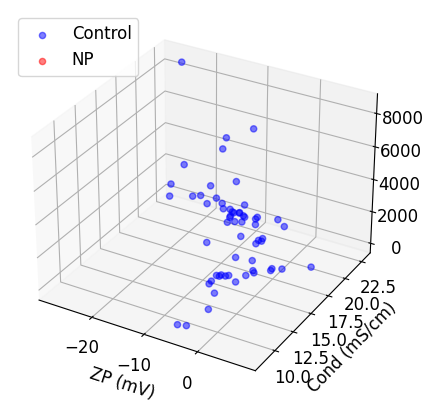

In [62]:
# Create the 3D scatter plot
pred = y_pred_LR
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(5,5))
# ax = plt.subplot(1,1,1,projection='3d')
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X_test[pred==0,0], X_test[pred==0,2], X_test[pred==0,3], c='blue', marker='o', label='Control',alpha=0.5)
ax.scatter(X_test[pred==1,0], X_test[pred==1,2], X_test[pred==1,3], c='red', marker='o', label='NP',alpha=0.5)
ax.set_xlabel('ZP (mV)')
ax.set_ylabel('Cond (mS/cm)')
# ax.tick_params("z", which="major",length=15,width = 2.0)
ax.legend(loc='upper left')
# ax.set_box_aspect((1.5,1.5,1)) 
plt.savefig('./results_mouse_con_np/scatter_test_lr.jpg', dpi=300, bbox_inches='tight')
plt.tight_layout
plt.show()


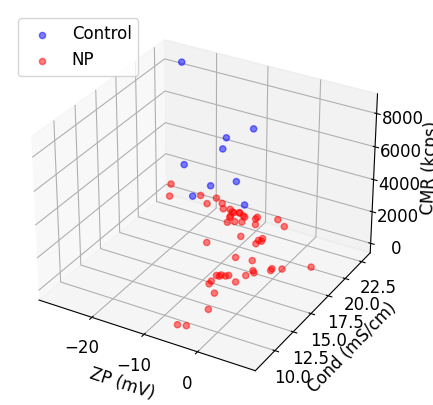

In [63]:
# Create the 3D scatter plot
pred = y_pred_SVM
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(5,5))
# ax = plt.subplot(1,1,1,projection='3d')
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X_test[pred==0,0], X_test[pred==0,2], X_test[pred==0,3], c='blue', marker='o', label='Control',alpha=0.5)
ax.scatter(X_test[pred==1,0], X_test[pred==1,2], X_test[pred==1,3], c='red', marker='o', label='NP',alpha=0.5)
ax.set_xlabel('ZP (mV)')
ax.set_ylabel('Cond (mS/cm)')
ax.set_zlabel('CMR (kcps)')
# ax.tick_params("z", which="major",length=15,width = 2.0)
ax.legend(loc='upper left')
# ax.set_box_aspect((1.5,1.5,1)) 
plt.savefig('./results_mouse_con_np/scatter_test_svm.jpg', dpi=300, bbox_inches='tight')
plt.tight_layout
plt.show()

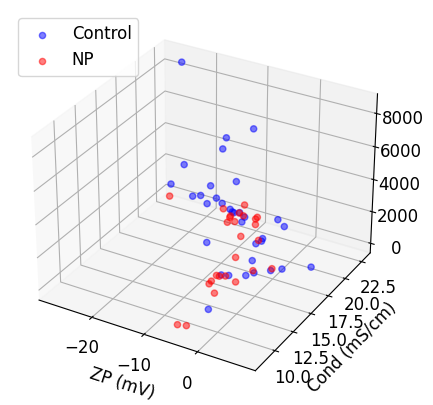

In [64]:
# Create the 3D scatter plot
pred = y_pred_kNN
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(5,5))
# ax = plt.subplot(1,1,1,projection='3d')
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X_test[pred==0,0], X_test[pred==0,2], X_test[pred==0,3], c='blue', marker='o', label='Control',alpha=0.5)
ax.scatter(X_test[pred==1,0], X_test[pred==1,2], X_test[pred==1,3], c='red', marker='o', label='NP',alpha=0.5)
ax.set_xlabel('ZP (mV)')
ax.set_ylabel('Cond (mS/cm)')
# ax.tick_params("z", which="major",length=15,width = 2.0)
ax.legend(loc='upper left')
# ax.set_box_aspect((1.5,1.5,1)) 
plt.savefig('./results_mouse_con_np/scatter_test_knn.jpg', dpi=300, bbox_inches='tight')
plt.tight_layout
plt.show()

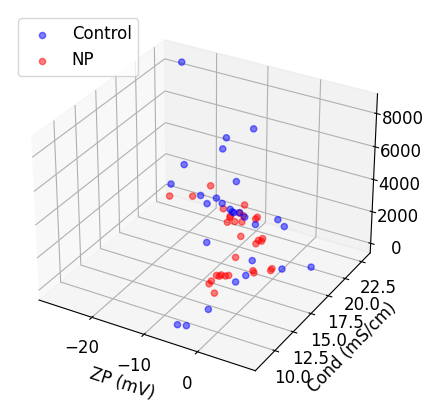

In [65]:
# Create the 3D scatter plot
pred = y_pred_DT
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(5,5))
# ax = plt.subplot(1,1,1,projection='3d')
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X_test[pred==0,0], X_test[pred==0,2], X_test[pred==0,3], c='blue', marker='o', label='Control',alpha=0.5)
ax.scatter(X_test[pred==1,0], X_test[pred==1,2], X_test[pred==1,3], c='red', marker='o', label='NP',alpha=0.5)
ax.set_xlabel('ZP (mV)')
ax.set_ylabel('Cond (mS/cm)')
# ax.tick_params("z", which="major",length=15,width = 2.0)
ax.legend(loc='upper left')
# ax.set_box_aspect((1.5,1.5,1)) 
plt.savefig('./results_mouse_con_np/scatter_test_dt.jpg', dpi=300, bbox_inches='tight')
plt.tight_layout
plt.show()

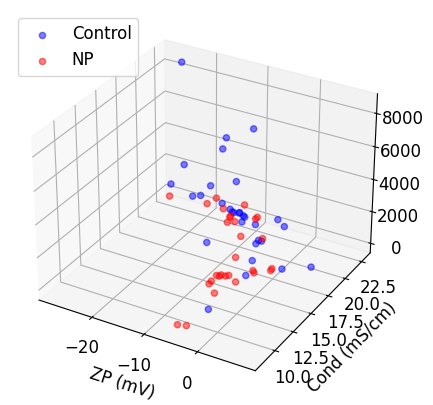

In [66]:
# Create the 3D scatter plot
pred = y_pred_XGB
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(5,5))
# ax = plt.subplot(1,1,1,projection='3d')
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X_test[pred==0,0], X_test[pred==0,2], X_test[pred==0,3], c='blue', marker='o', label='Control',alpha=0.5)
ax.scatter(X_test[pred==1,0], X_test[pred==1,2], X_test[pred==1,3], c='red', marker='o', label='NP',alpha=0.5)
ax.set_xlabel('ZP (mV)')
ax.set_ylabel('Cond (mS/cm)')
# ax.tick_params("z", which="major",length=15,width = 2.0)
ax.legend(loc='upper left')
# ax.set_box_aspect((1.5,1.5,1)) 
plt.savefig('./results_mouse_con_np/scatter_test_xgb.jpg', dpi=300, bbox_inches='tight')
plt.tight_layout
plt.show()
# print(sum(pred==0)) # double check the number